IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import random
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
from tensorflow.keras.callbacks import EarlyStopping
import zipfile
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

load data


In [ ]:
zip_path = "/content/emotion data.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("emotion_dataset1")

In [ ]:
def reduce_dataset(source_dir, target_dir, max_images_per_class=200):
    source_dir = Path(source_dir)
    target_dir = Path(target_dir)
    target_dir.mkdir(parents=True, exist_ok=True)

    for class_folder in source_dir.iterdir():
        if class_folder.is_dir():
            images = list(class_folder.glob("*"))
            selected_images = random.sample(images, min(len(images), max_images_per_class))
            dest_class_folder = target_dir / class_folder.name
            dest_class_folder.mkdir(parents=True, exist_ok=True)

            for img_path in selected_images:
                shutil.copy(img_path, dest_class_folder / img_path.name)
            print(f"Copied {len(selected_images)} images to {dest_class_folder}")

reduce_dataset(TRAIN_DIR, '/content/reduced/train', max_images_per_class=200)
reduce_dataset(TEST_DIR, '/content/reduced/test', max_images_per_class=200)

Copied 200 images to /content/reduced/train/angry
Copied 200 images to /content/reduced/train/happy
Copied 200 images to /content/reduced/train/sad
Copied 200 images to /content/reduced/train/disgust
Copied 200 images to /content/reduced/train/fear
Copied 200 images to /content/reduced/train/surprise
Copied 200 images to /content/reduced/train/neutral
Copied 200 images to /content/reduced/test/angry
Copied 200 images to /content/reduced/test/happy
Copied 200 images to /content/reduced/test/sad
Copied 200 images to /content/reduced/test/disgust
Copied 200 images to /content/reduced/test/fear
Copied 200 images to /content/reduced/test/surprise
Copied 200 images to /content/reduced/test/neutral


In [ ]:
TRAIN_DIR = '/content/reduced/test'
TEST_DIR = '/content/reduced/train'

In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(os.path.join(directory, label)):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels


In [ ]:
# Convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)

# Shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()


angry Completed
happy Completed
sad Completed
disgust Completed
fear Completed
surprise Completed
neutral Completed


,image,label
0,/content/reduced/test/neutral/Training_5960744...,neutral
1,/content/reduced/test/angry/Training_85847931.jpg,angry
2,/content/reduced/test/angry/Training_19778378.jpg,angry
3,/content/reduced/test/disgust/Training_9914215...,disgust
4,/content/reduced/test/surprise/Training_879400...,surprise


In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

angry Completed
happy Completed
sad Completed
disgust Completed
fear Completed
surprise Completed
neutral Completed


,image,label
0,/content/reduced/train/angry/Training_87594829...,angry
1,/content/reduced/train/angry/Training_56341469...,angry
2,/content/reduced/train/angry/PrivateTest_90676...,angry
3,/content/reduced/train/angry/Training_96928714...,angry
4,/content/reduced/train/angry/Training_13489272...,angry


DATA ANALSIS


<Axes: xlabel='count', ylabel='label'>

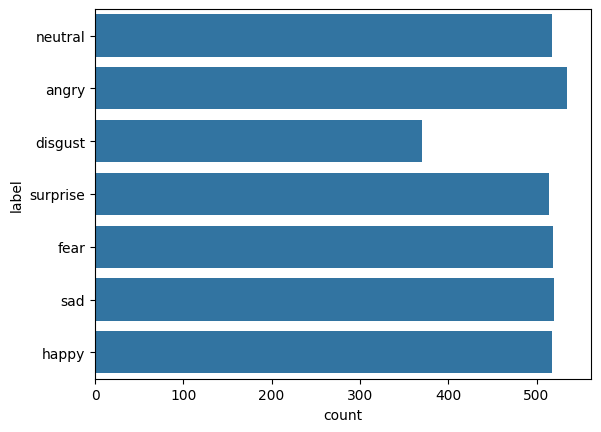

In [ ]:
sns.countplot(train['label'])

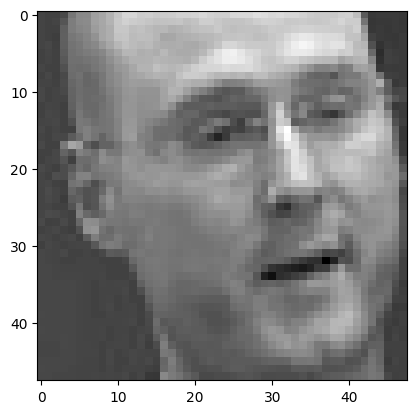

In [ ]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

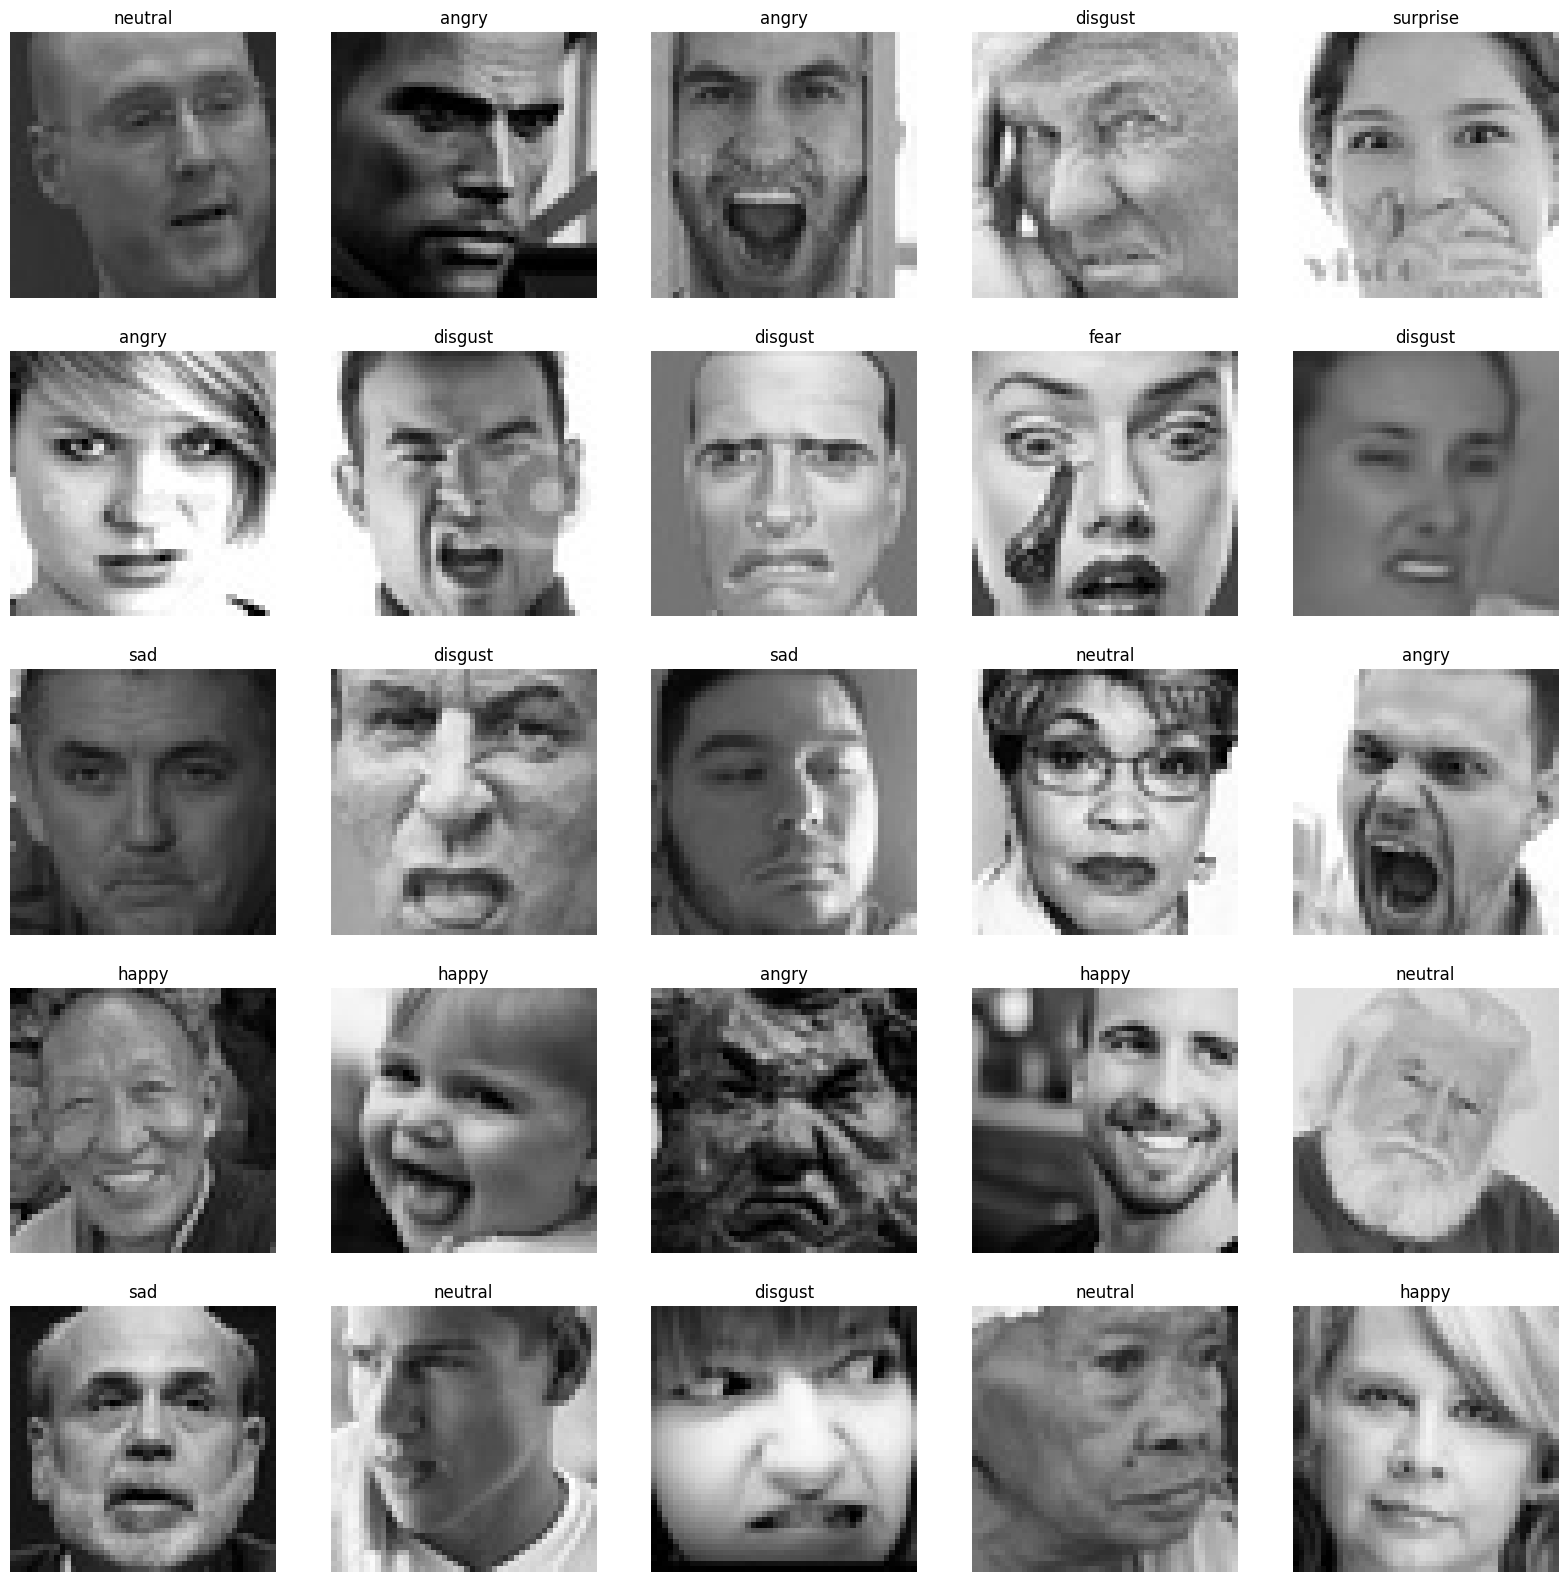

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

FEATURE EXTRACTING


In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode="grayscale")
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [ ]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0.])

In [ ]:
input_shape = (48, 48, 1)
output_class = 7

Model Creation

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 578ms/step - accuracy: 0.1517 - loss: 1.9501 - val_accuracy: 0.1524 - val_loss: 1.9421
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 641ms/step - accuracy: 0.1663 - loss: 1.9403 - val_accuracy: 0.1728 - val_loss: 1.9381
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - accuracy: 0.1893 - loss: 1.9360 - val_accuracy: 0.2211 - val_loss: 1.9204
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.1941 - loss: 1.9182 - val_accuracy: 0.2043 - val_loss: 1.9007
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 645ms/step - accuracy: 0.2153 - loss: 1.8990 - val_accuracy: 0.2472 - val_loss: 1.8616
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 643ms/step - accuracy: 0.2381 - loss: 1.8598 - val_accuracy: 0.2877 - val_loss: 1.7980
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 580ms/step - accuracy: 0.2625 - loss: 1.8039 - val_accuracy: 0.3097 - val_loss: 1.7669
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 646ms/step - accuracy: 0.2996 - loss: 1.7735 - val_accu

RESULTS

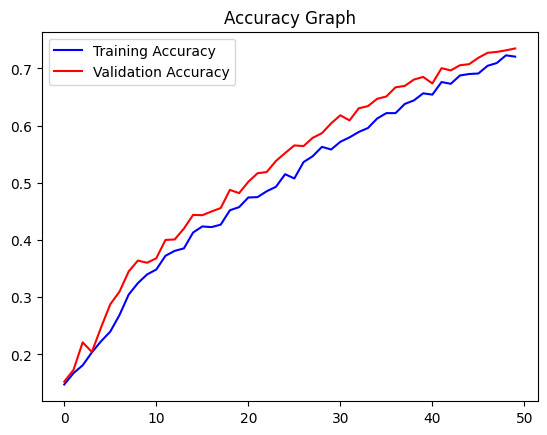

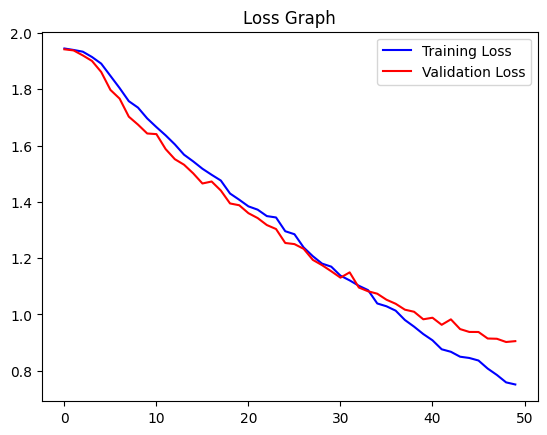

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step


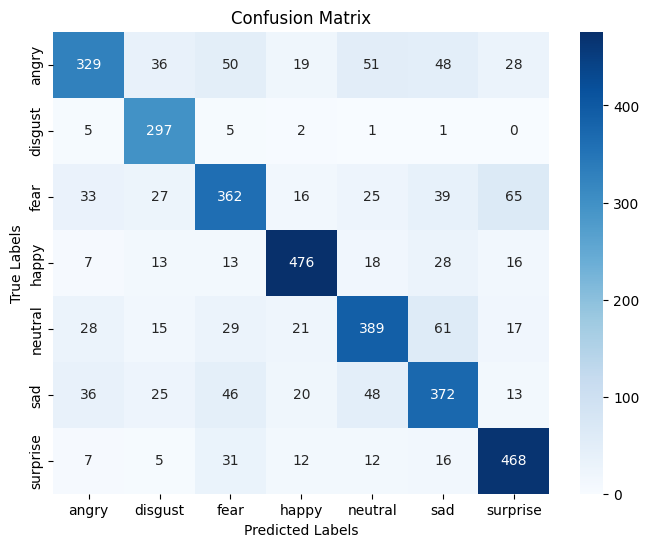

F1 Score: 0.7283247245584268


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Compute the F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')  
print(f"F1 Score: {f1}")


Test with Image Data


Original Output: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Output: fear


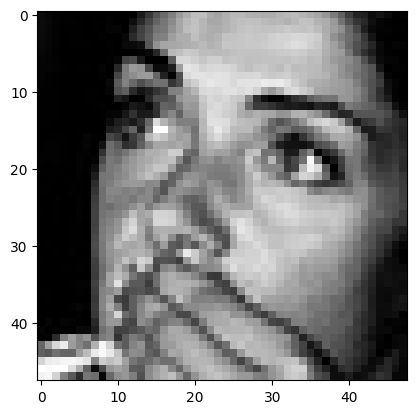

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Output: disgust


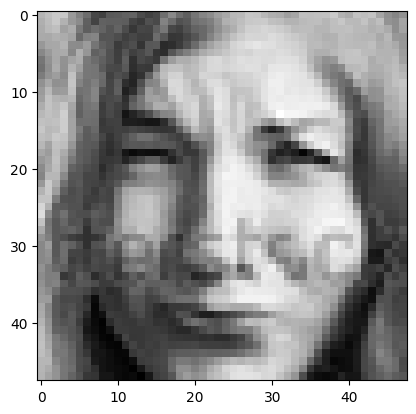

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Output: happy


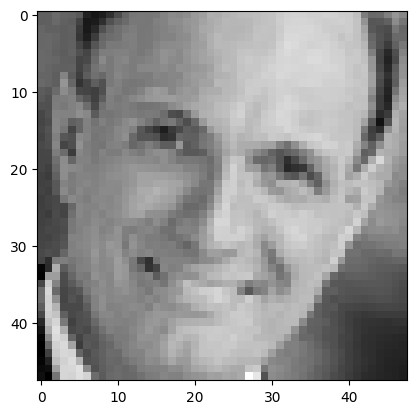

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');